In [2]:
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
import collections
#import pyfluidsynth

from pathlib import Path
import pretty_midi
import librosa.display
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

%run midi_util.py

file = 'train/train.mid'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## midi notes file

In [3]:
pm = pretty_midi.PrettyMIDI(file)

In [4]:
pianoroll = pm.get_piano_roll(fs=100)[60:72].T
curr_note = 13 #note 13 is pause
counter = 0
notes_list = []
times_list = []
for i, timestep in enumerate(pianoroll):
    new_note = np.argmax(timestep)
    if new_note == 0 and timestep[new_note] == 0:
        new_note = 13
    if new_note != curr_note:
        curr_length = int(np.round(counter/30)) # ERROR PRONE
        if curr_length > 0:
            notes_list.append(curr_note)
            times_list.append(curr_length)
        counter = 1
        curr_note = new_note
    else:
        counter += 1
        
# throw out first dummy sample
notes = np.array(notes_list[1:])
times = np.array(times_list[1:])
notes.shape, notes.shape == times.shape, notes[:30],times[:30]

((1050,),
 True,
 array([10,  5,  0,  7, 10,  5,  0,  7, 10,  5,  0,  7, 10,  7, 10,  5,  6,
         7, 10,  5,  6,  7, 10,  7, 10,  5,  0,  7, 10,  5]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]))

### Decision: Chord Dictionary(>10 chords one hot) & Root note (lowest, 11 one hot)
new decision: chord dict later, first baseline with chords as binary (11 multihot)

## notes list with context chord vector

In [5]:
pianoroll = pm.get_piano_roll(fs=100)[48:72].T
curr_note = 13 #note 13 is pause
counter = 0
newnote = True
chords_list, notes_list, times_list = [], [], []
for i, timestep in enumerate(pianoroll):
    if newnote:
        newnote = False
        chord = np.zeros(12)
        notes_in_chord = timestep[:12].nonzero()[0]
        if notes_in_chord != []:
            chord[notes_in_chord] = 1
    nnz = timestep.nonzero()[0]
    if nnz != []:
        new_note = np.max(nnz)
    else:
        new_note = 13
    if new_note != curr_note:
        curr_length = int(np.round(counter/30)) # ERROR PRONE
        if curr_length > 0:
            notes_list.append(curr_note)
            times_list.append(curr_length)
            chords_list.append(chord)
        counter = 1
        curr_note = new_note
        newnote = True
    else:
        counter += 1
        

notes = np.array(notes_list)
times = np.array(times_list)
chords = np.array(chords_list)
notes.shape, notes.shape == times.shape, notes[:10],times[:10], chords[:10]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  


((1101,),
 True,
 array([19, 22, 17, 12, 19, 22, 17, 12, 19, 22]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([[1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]]))

# combine to one feature vector

In [6]:
# input size 12+3+12+12 = 39 (noch keine triolen)
features = []
targets = []
for i, note in enumerate(notes):
    elt = np.zeros(39)
    targ = np.zeros(12)
    elt[notes[i]-12] = 1
    elt[12+times[i]] = 1
    elt[15:27] = chords[i]
    if i < len(notes)-1:
        elt[27:] = chords[i+1]
        targ[notes[i+1]-12] = 1
        features.append(elt)
        targets.append(targ)
features = np.array(features)
targets = np.array(targets)
features.shape, targets.shape

((1100, 39), (1100, 12))

In [7]:
# stripped down version
# input size 12+12 = 24 (noch keine triolen)
features = []
for i, note in enumerate(notes):
    elt = np.zeros(24)
    elt[notes[i]-12] = 1
    elt[12:] = chords[i]
    if i < len(notes)-1:
        features.append(elt)
features = np.array(features)
features.shape

(1100, 24)

In [8]:
features[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0.])

# get Net Input Sequences

In [9]:
# TODO: add times to label?

seq_len = 16
sequences = []
labels = []
i = 0
while i+seq_len < features.shape[0]:
    sequences.append(features[i:i+seq_len])
    label = np.argmax(features[i+seq_len,:12]) # error prone?
    labels.append(label)
    #i += seq_len
    i += 1
    
sequences = np.array(sequences)
labels = np.array(labels)
sequences.shape, labels.shape

((1084, 16, 24), (1084,))

In [33]:
#cap 50 for overfitting
n = 32
train_data = sequences[:n]
train_labels = labels[:n]

train_data.shape, train_labels.shape

((32, 16, 24), (32,))

In [34]:
counter = collections.Counter(train_labels)
display(counter)
for elt in counter:
    counter[elt] = 1. / counter[elt]
weights  = []
for i in range(12): # error prone
    weights.append(counter.get(i,0))
weights = torch.Tensor(weights)

Counter({5: 6, 6: 4, 7: 6, 10: 7, 0: 5, 3: 3, 2: 1})

## Load Data for Pytorch

In [48]:
batch_size = 32

class Dataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels, transform=None):
        super(Dataset, self).__init__()
        self.inputs = inputs
        self.labels = labels
        self.transform = transform
       
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        inputs = self.inputs[idx]
        label = self.labels[idx]
        if self.transform: 
            inputs = self.transform(inputs)
        return inputs, label
    
dataset = Dataset(train_data, train_labels)   

train_weights=weights[train_labels]
sampler = torch.utils.data.WeightedRandomSampler(
    weights=train_weights,
    num_samples=len(train_weights),
    replacement=True)
train_loader = torch.utils.data.DataLoader(dataset=dataset,  batch_size=batch_size)

## Model

In [49]:
#####################
# Build model
#####################

class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.hidden = self.init_hidden(batch_size)

        # Define the LSTM layer
        self.lstm = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=0.5
        )
        
        self.bn2 = nn.BatchNorm1d(hidden_size)
        
        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self, batch_size):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))

    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        fc_input = lstm_out[:,-1,:]
        #fc_input = self.bn2(lstm_out[:,-1,:])
        
        # Only take the output from the final timetep
        y_pred = self.linear(fc_input)
        log_probs = F.log_softmax(y_pred,dim=1) # crossentropy is already with softmax
        return y_pred
    
# evaluation
def evaluation():
    model.eval()
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        batch_size = inputs.size(0)
        model.hidden = model.init_hidden(batch_size)

        optim.zero_grad()
        outputs = model(inputs.float())

        if i == 0:
            all_outputs = np.array(outputs.detach().numpy())
        else:
            all_outputs = np.append(all_outputs, outputs.detach().numpy(),axis=0)
            
    predicted_notes = np.argmax(all_outputs,axis=1)
    
    acc = (predicted_notes == train_labels).sum() / train_labels.shape[0]
    model.train()
    return predicted_notes, acc

In [50]:
# Model params
input_size = train_data.shape[-1] 
output_dim = 12
hidden_size = 64
num_layers = 2
dtype = torch.float

model = LSTM(input_size, hidden_size, output_dim=output_dim, num_layers=num_layers)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

57228

loss:  0.1729 acc:  0.66
predicted_notes [ 6  7  7  7 10  6  7 10 10 10  7  7  7  7  7  7  7  0  3  6  5 10  5  3
  3  3 10  6  2  7  0 10]
loss:  0.2618 acc:  1.0
loss:  0.1821 acc:  1.0
loss:  0.1371 acc:  1.0
loss:  0.1507 acc:  1.0
loss:  0.1114 acc:  1.0
predicted_notes [ 5  6  7 10  5  6  7 10  7 10  5  0  7 10  5  0  7  0  3  6  5 10  5  3
  0  3 10  6  2  7  0 10]
loss:  0.1152 acc:  1.0
loss:  0.0876 acc:  1.0
loss:  0.0788 acc:  1.0
loss:  0.0707 acc:  1.0
loss:  0.0574 acc:  1.0
predicted_notes [ 5  6  7 10  5  6  7 10  7 10  5  0  7 10  5  0  7  0  3  6  5 10  5  3
  0  3 10  6  2  7  0 10]
loss:  0.0519 acc:  1.0
loss:  0.0583 acc:  1.0
loss:  0.0644 acc:  1.0
loss:  0.0289 acc:  1.0
loss:  0.0399 acc:  1.0
predicted_notes [ 5  6  7 10  5  6  7 10  7 10  5  0  7 10  5  0  7  0  3  6  5 10  5  3
  0  3 10  6  2  7  0 10]
loss:  0.0431 acc:  1.0
loss:  0.029 acc:  1.0
loss:  0.0196 acc:  1.0
loss:  0.0234 acc:  1.0


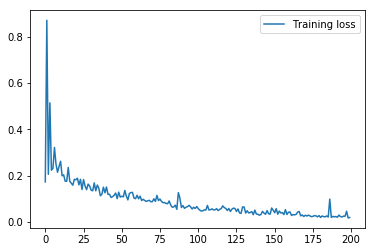

In [53]:
#####################
# Train model
#####################

# Train params
learning_rate = 1e-3
num_epochs = 200
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

#loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.CrossEntropyLoss()
#loss_fn = torch.nn.NLLLoss(weight=weights, reduction='sum')

hist = np.zeros(num_epochs)

def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)

for t in range(num_epochs):
    loss_curr = 0
    for i, (inputs, targets) in enumerate(train_loader, 1):
        inputs, targets = inputs.to(device), targets.to(device)
        
        batch_size = inputs.size(0)
        model.hidden = model.init_hidden(batch_size)
        
        optim.zero_grad()
        outputs = model(inputs.float())
        
        loss = loss_fn(outputs, targets.long())
        #loss = loss_fn(outputs, targets.float())
        
        loss.backward(retain_graph=True)
        #clip_gradient(model, 1e-1)
        optim.step()

        loss_curr = loss_curr + loss.item()
        
    hist[t] = loss_curr
    if t%10==0:
        predicted_notes, acc = evaluation()
        print("loss: ", np.round(hist[t], 4), "acc: ", np.round(acc,2))
        
        if t%50==0:
            print("predicted_notes", predicted_notes)
        

#####################
# Plot preds and performance
#####################

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [54]:
train_labels

array([ 5,  6,  7, 10,  5,  6,  7, 10,  7, 10,  5,  0,  7, 10,  5,  0,  7,
        0,  3,  6,  5, 10,  5,  3,  0,  3, 10,  6,  2,  7,  0, 10])

## Create Sample

In [30]:
axe = np.zeros((outputs.shape[0],outputs.shape[1]-1))
for i in range(outputs.shape[0]):
    index = int(outputs[i].detach().max(0)[1])
    if index < 25:
        axe[i,index] = 1
axe.shape

createMidiFromPianoRoll(axe, low, 'treval', 'netout', tempo=200, threshold=0.1, resolution=8)

In [10]:
pm = pretty_midi.PrettyMIDI('treval/netout.mid')


fs = 44000
IPython.display.Audio(pm.synthesize(fs=44000), rate=44000)

In [235]:
#createMidiFromPianoRoll(y2[:50,:25], low, 'treval', 'realout', tempo=200, threshold=0.1, resolution=8)

In [134]:
outputs = []
for i, (inputs, targets) in enumerate(train_loader, 1):
    inputs, targets = inputs.to(device), targets.to(device)

    batch_size = inputs.size(0)
    model.hidden = model.init_hidden(batch_size)

    output = model(inputs.float())
    outputs.append(output.detach().numpy())

# Examples and Visuals

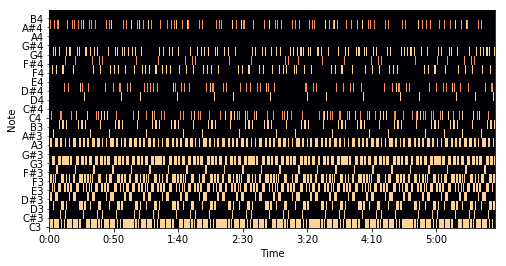

In [10]:
fs = 8
pm = pretty_midi.PrettyMIDI("train/train.mid")
piano_midi = pm.instruments[0] # Get the piano channels
piano_roll = piano_midi.get_piano_roll(fs=fs)
piano_roll = piano_roll[48:72].T

def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

plt.figure(figsize=(8, 4))
plot_piano_roll(pm, 48, 72)

In [7]:
files_dir = "train/"
files_dir = glob.glob("%s*.mid" %(files_dir))
resolution = 8 #ticks per beat

low, high, ticks = getNoteRangeAndTicks(files_dir)
tr = fromMidiCreatePianoRoll(files_dir, ticks, low, high)
#createMidiFromPianoRoll(tr[0], low, "treval/", 'test', tempo=200)

In [8]:
# smallest LSTM example
rnn = nn.LSTM(input_size=10, hidden_size=20, num_layers=2, batch_first=True) # It was batch_first=True!
inputs = torch.randn(5, 300, 10)
hidden = (torch.randn(2, 5, 20), torch.randn(2, 5, 20))
output, hidden = rnn(inputs, hidden)
output.shape

torch.Size([5, 300, 20])

# Train Val Split

In [9]:
def standardize(data):
    """ Move {0,1} data to {-1,1}, then standardize. Standardize data in [0,1]"""
    data = data.astype(np.float32)
    standardized_data = (data - np.mean(data, axis=0)[None,:,:]) / np.std(data, axis=0)[None,:,:]
    return standardized_data

In [11]:
a = standardize(train_data)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [22]:
np.std(train_data, axis=0)

array([[0.        , 0.        , 0.37371718, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.37371718, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.37371718, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [23]:
train_data[0]

array([[ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])